author: KeczerZs

This school project is an implemenation of Newman's (2004a) greedy modularity
maximatization algorithm and its improved version by Clauset, Newman and Moore (2004b). 

References:
Newman, M. E. (2004a). Fast algorithm for detecting community structure in networks. Physical review E, 69(6), 066133.
Clauset, A., Newman, M. E., & Moore, C. (2004b). Finding community structure in very large networks. Physical review E, 70(6), 066111.

The code of greedyQ function is also based on networkx library codes by Edward L. Platt.

References: 
https://networkx.github.io/documentation/latest/_modules/networkx/algorithms/community/modularity_max.html
https://github.com/networkx/networkx/blob/master/networkx/algorithms/community/modularity_max.py

The test_community.py is the work of Thomas Aynaud et al. (2009).
In this project, the implementaiton of the Girvan-Newman test graph is used from test_community.

References:
Girvan newman, 2002. PNAS June, vol 99 n 12
https://github.com/taynaud/python-louvain/blob/master/test_community.py
https://python-louvain.readthedocs.io/en/latest/

In [5]:
# Dependecies for the the algorithms below
import networkx as nx
from networkx.algorithms import community
from random import random
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [1]:
def greedyQ(graph, weighted = False):
    '''
    Original codes are the work of Edward L. Platt
    
    Current version:
    -For undirected and unweighted/weighted networks    
    -For node labels that are consecutive integers from 0 to N-1 in the input graph
     where N is the number of nodes
     Example for input node labels (undirected, unweighted graph with 7 nodes):
     > graph.nodes()
     > NodeView((0, 1, 2, 3, 4, 5, 6))
     
    This function uses networx library.
    > import networkx
    > from networkx.algorithms import community
    
    graph : networkx graph object (undirected and unweighted, node labes from 0 to N-1)
        
    TODO
    -Solve arbitrary node labels
    -Solve implemention with a heap
    -Test with weighted graphs       
        
    Returns communities : list of forzen sets (communities at the maximum Q value)
    '''
    
    # Constants (capitalized): graph data
    # number of nodes
    N = len(graph.nodes()) 
    # number of edges
    M = len(graph.edges()) 
    # list of ints, degrees of nodes in order
    DEGREES = [graph.degree()[i] for i in range(N)]
    if weighted:
        # dict of floats, node strengths in order
        STRENGTHS = {node : 0 for node in graph.nodes()}
        for source,target,attrs in graph.edges(data=True):
            STRENGTHS[source] += attrs['weight']
            STRENGTHS[target] += attrs['weight']
        # float, number of edges (weighted)   
        W = sum(STRENGTHS.values())/2.0        
    
    # Initialize community and merge lists
    # commintiy merging (alway i into j) happens with set joining operation
    communities = {i : frozenset([i]) for i in range(N)}
    # keeping track of community merges, elements: (i, j, deltaQ_ij, Q)
    communityMerges = []
    
    # Initial modularity value (Q)
    # each node is considered as a community
    partition = [list(c) for c in communities.values()]
    # calculatin Q using networkx.algorithms.community namespace
    Q = community.modularity(graph, partition)
    
    # Initial data for while loop   
    # half of the fraction of edges btw communities i and j (each community has one node at first)
    # (variable name Eij is from the Clauset, Newman and Moore article)
    if weighted:
        Eij = {i: 
                {j: graph.get_edge_data(i,j)['weight']/(2.0*W) 
                 for j in graph.neighbors(i) if j!= i
                } 
              for i in range(N)
             }
        # fraction of half-edges in each community
        # (variable name a is from the Clauset, Newman and Moore article)
        a = [STRENGTHS[i] / (2.0*W) for i in range(N)]
        # nested dictionary represenation of matrix cells where there are edges in the orginial adjecency matrix
        # outer key i represents the row index, inner key j represents the coloumn index
        deltaQ = {i: 
                    {j: 2*Eij[i][j] - 2*STRENGTHS[i]*STRENGTHS[j]*(1/(2*W))**2 
                     for j in graph.neighbors(i) if j!= i
                    } 
                  for i in range(N)
                 }
    else:
        Eij = 1.0 / (2.0*M) 
        # fraction of half-edges in each community
        # (variable name a is from the Clauset, Newman and Moore article)
        a = [DEGREES[i] / (2.0*M) for i in range(N)]   
        # nested dictionary represenation of matrix cells where there are edges in the orginial adjecency matrix
        # outer key i represents row index, inner key j represents coloumn index
        deltaQ = {i: 
                    {j: 2*Eij - 2*DEGREES[i]*DEGREES[j]*Eij**2 
                     for j in graph.neighbors(i) if j!= i
                    } 
                  for i in range(N)
                 }           
    
    # we remove keys (representig matrix rows) from deltaQ in each iteraton, 
    # we can iterate until all nodes are in one community (one key remains in deltaQ)
    # alternatively: we can iterate till the Q value increases, then break from the loop
    while len(deltaQ) > 1:         
              
        # Select maximum deltaQ value and its coordinates (i and j)
        # For this, a heap was used in the orginial article, which yields better speed performance
        # i : j of max deltaQ (row coordinate to row maximum coordinate)
        iTojOfMaxDeltaQ_dict = {i : max(deltaQ[i].keys(), key=(lambda j: deltaQ[i][j])) for i in deltaQ}
         # i : row max deltaQ value (row coordinate to row maximum value)
        iToMaxDeltaQ_dict = {i : deltaQ[i][iTojOfMaxDeltaQ_dict[i]] for i in deltaQ}   
        # i coordinate (row coodinate with the highest of the row maximum deltaQ values)
        maxDeltaQ_i = max(iToMaxDeltaQ_dict.keys(), key=(lambda i: iToMaxDeltaQ_dict[i])) 
        # j coordinate (the row maximum coordinate in the row i)
        maxDeltaQ_j = iTojOfMaxDeltaQ_dict[maxDeltaQ_i] 
        # maximum deltaQ value (at the i and j coordinates)
        maxDeltaQ_value =  deltaQ[maxDeltaQ_i][maxDeltaQ_j] 
        
        # Increment Q by the maximum delta Q value
        Q += maxDeltaQ_value

        # Breaking out of the loop if Q value does not increase
        if len(communityMerges) > 0 and Q <= communityMerges[-1][-1]:
            break          
        
        # Merge communities (i and j) yielding maximum deltaQ:
        i, j = maxDeltaQ_i, maxDeltaQ_j
        communities[j] = frozenset(communities[i] | communities[j])
        del communities[i]
        communityMerges.append((i, j, maxDeltaQ_value, Q))        
        
        # Find values to update in detlaQ (for communities connected to communities i and j)
        neighbors_i = set(deltaQ[i].keys())
        neighbors_j = set(deltaQ[j].keys())
        allNeighbors_ij = (neighbors_i | neighbors_j) - set([i, j])
        commonNeighbors_ij = neighbors_i & neighbors_j
        
        # Merge community i into j
        # (variable name k is from the Clauset, Newman and Moore article)
        for k in allNeighbors_ij:
            # calculate new deltaQ value
            if k in commonNeighbors_ij:
                deltaQ_jk = deltaQ[j][k] + deltaQ[i][k]
            elif k in neighbors_j:
                deltaQ_jk = deltaQ[j][k] - 2.0*a[i]*a[k]
            else: # k in neighbors_i
                deltaQ_jk = deltaQ[i][k] - 2.0*a[j]*a[k]          
            # Update dictionary DeltaQ I.: for rows j and k (i is removed below) 
            deltaQ[j][k] = deltaQ_jk
            deltaQ[k][j] = deltaQ_jk 
        # end of for                
        
        # Update the dictionary DeltaQ II.: row i is removed here
        # remove row and column i
        for k in neighbors_i:
            # remove i from coloumns
            del deltaQ[k][i]  
        # remove row i
        del deltaQ[i] 
        
        # Update list elements a[j] and a[i]
        a[j] += a[i]
        a[i] = 0 
        
        # Remove components
        # collecting rows without deltaQ data
        keysForDeletion = []
        for i in deltaQ.keys():
            if len(deltaQ[i]) == 0:
                keysForDeletion.append(i)
        # deleting rows witout deltaQ data        
        for k in keysForDeletion:
            del deltaQ[k]
               
    #end of while 
    
    # Returning partion at maximum Q value
    communities = [frozenset(c) for c in communities.values()]
    return sorted(communities, key=len, reverse=True)

In [32]:
def createTestGraph1():
    '''
    Creates a simple, undirected and unweighted test graph with 7 nodes.
    
    The test graph G has two fully-connected clusters and there is
    a single-node bridge between the clusters.
    
    This function uses networx library.
    > import networkx
    
    Example:
    > G = createTestGraph1()
    > nx.draw(G)
    > G.nodes()
    > NodeView((0, 1, 2, 3, 4, 5, 6))
    > print(community.modularity(G, [[0, 1, 2], [3, 4, 5, 6]]))
    > 0.35499999999999987
    
    returns G : networkx graph object
    '''
    G = nx.Graph()

    #cluster 1 : 0,1,2
    G.add_edge(0,1)
    G.add_edge(0,2)
    G.add_edge(1,2)
    
    #bridge
    G.add_edge(2,3)
    
    #cluster 2 : 3,4,5,6
    G.add_edge(3,4)
    G.add_edge(3,5)
    G.add_edge(3,6)
    G.add_edge(4,5)
    G.add_edge(4,6)
    G.add_edge(5,6)
    
    return G

###  A simple test code

[frozenset({3, 4, 5, 6}), frozenset({0, 1, 2})]


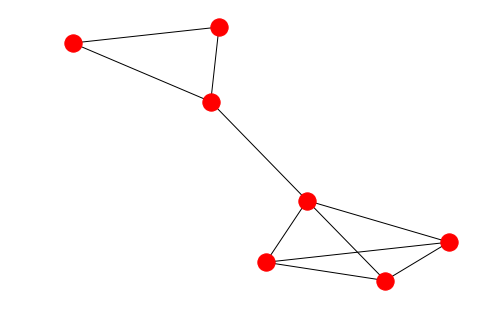

In [33]:
# create the test graph: undirected and unweighted test graph with 7 nodes
G = createTestGraph1()
nx.draw(G)

# run the greedyQ function to find the best partition
bestPartition = greedyQ(G)
print(bestPartition)

In [34]:
def girvan_graphs(zout) :
    """
    Create a graph of 128 vertices, 4 communities, like in
    Community Structure in  social and biological networks.
    Girvan newman, 2002. PNAS June, vol 99 n 12
    
    This function is the work of Thomas Aynaud et al. (2009)
    References:
    https://github.com/taynaud/python-louvain/blob/master/test_community.py
    https://python-louvain.readthedocs.io/en/latest/
    """

    pout = float(zout)/96.
    pin = (16.-pout*96.)/31.
    graph = nx.Graph()
    graph.add_nodes_from(range(128))
    for x in graph.nodes() :
        for y in graph.nodes() :
            if x < y :
                val = random()
                if x % 4 == y % 4 :
                    #nodes belong to the same community
                    if val < pin :
                        graph.add_edge(x, y)

                else :
                    if val < pout :
                        graph.add_edge(x, y)
    return graph

In [43]:
def classicGNTest(Zout):
    '''
    This function generates a Girvan-Newman test network with four modules 
    the network has 128 nodes (each module has 32 nodes)
    
    Zout : non-negative float
    
    It creates plots before and after the community detection.
    Each community has a different random color after the community detection.    
    '''    
    # Create a Girvan-Newman test graph
    G = girvan_graphs(Zout)
    
    # Draw the generated network before detecting communities
    nx.draw(G, with_labels = True)
    
    # Run the community detection
    communities = greedyQ(G)
    communities.sort(key = (lambda community: sorted(list(community))[0]))
    
    # Assign a community number to each node
    nodeToCommunity_dict = {node : c for c in range(len(communities)) for node in communities[c]}
        
    # Assign a random color to each community (RGB code in a tuple)
    communityToColor_dict = {c : (random(), random(), random()) for c in range(len(communities))}
    
    # Assign each a color to each node
    nodeColors = [communityToColor_dict[nodeToCommunity_dict[node]] for node in G.nodes()]
    
    # Fraction of correctly clustered nodes
    correctlyClustered = [node for node in nodeToCommunity_dict if node % 4 == nodeToCommunity_dict[node] % 4]
    fractionOfCorrectlyClustered = len(correctlyClustered)/len(G.nodes())
    
    # Draw network, each community has a different random color
    plt.figure()
    nx.draw(G, node_color = nodeColors, with_labels = True)    
            
    return

### Testing with the Girvan-Newman test graph

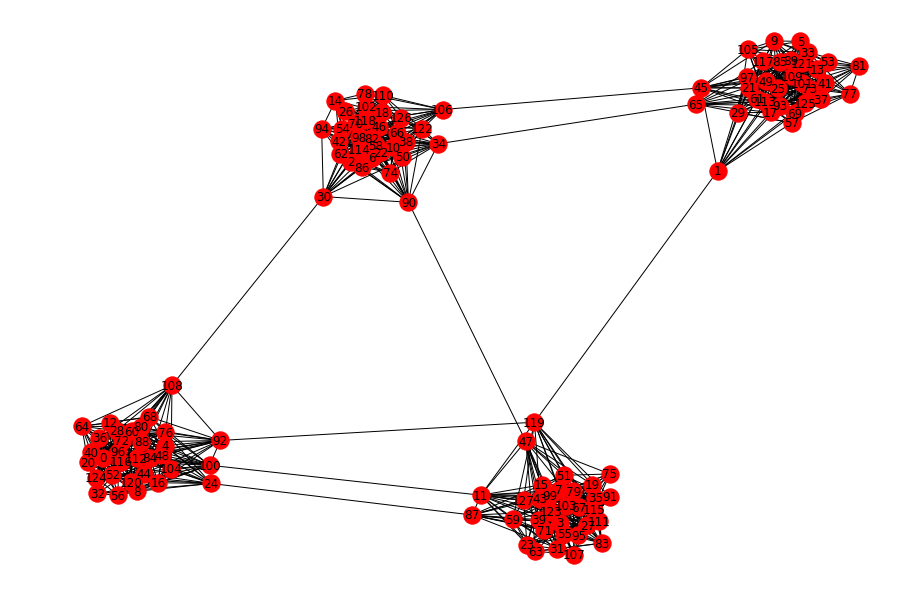

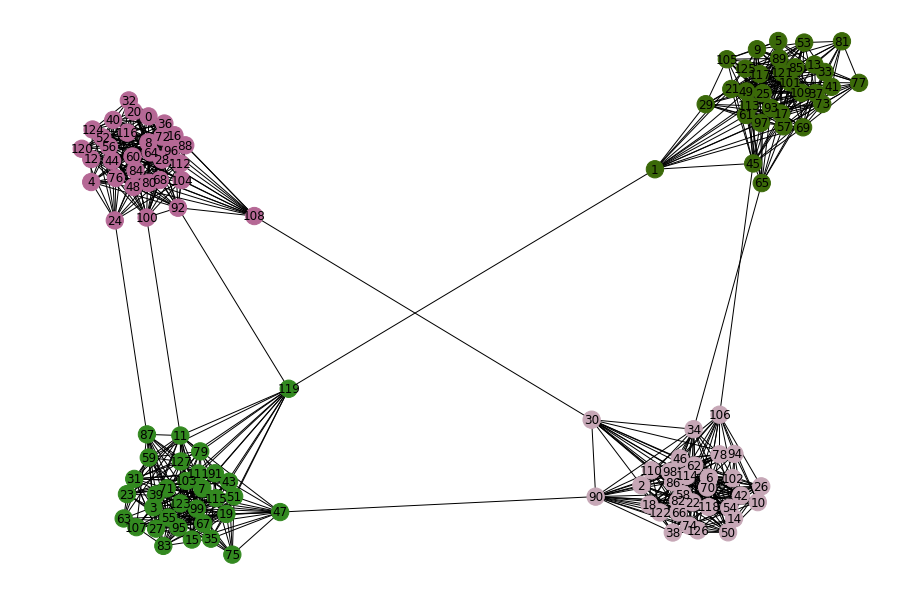

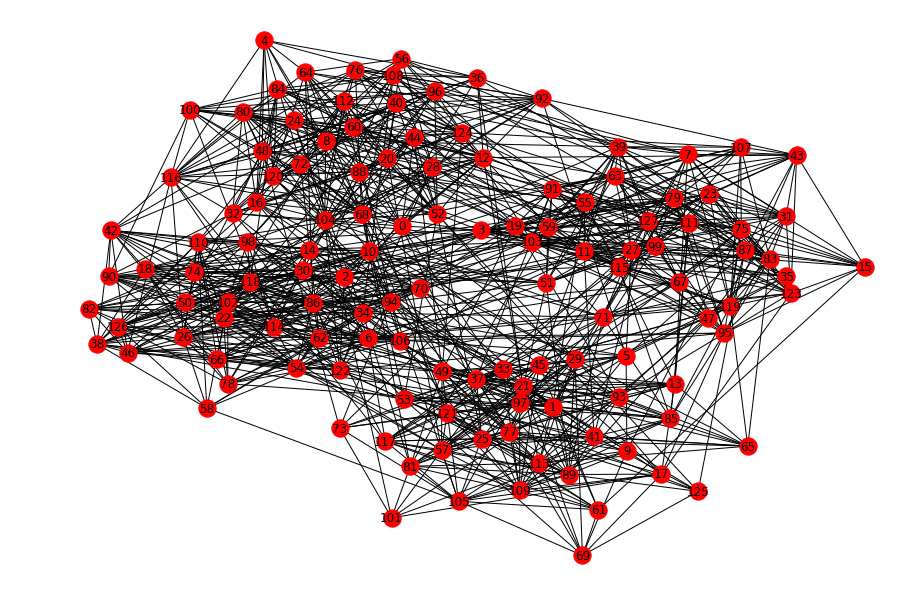

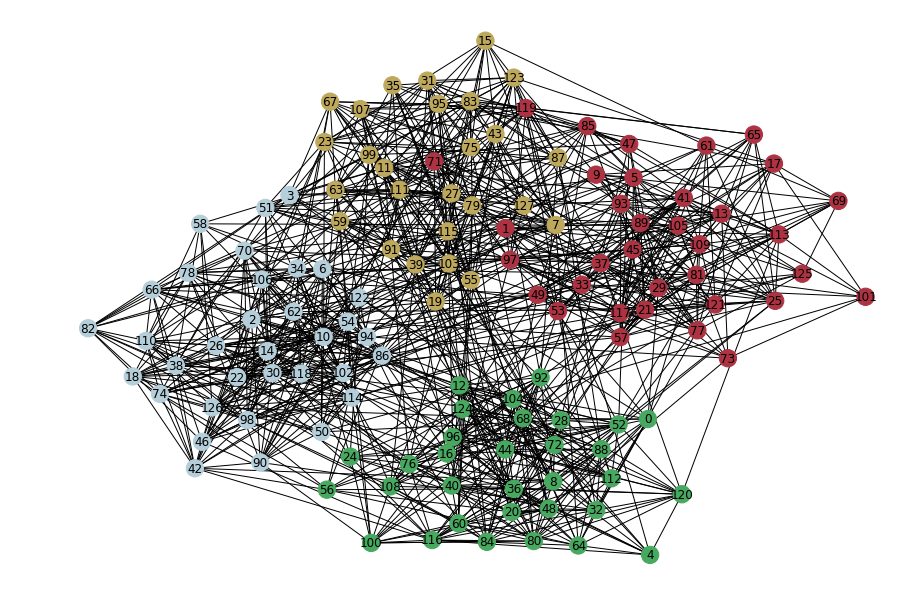

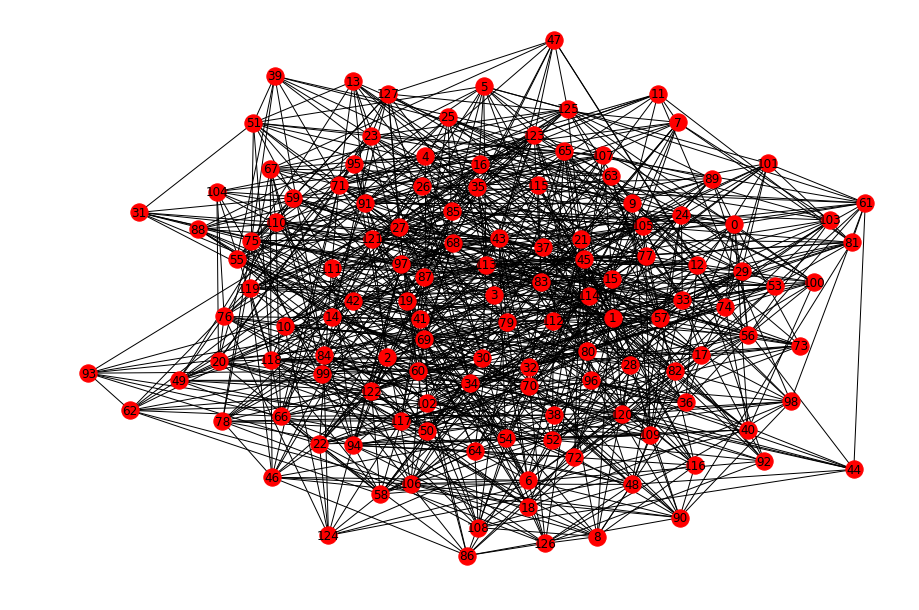

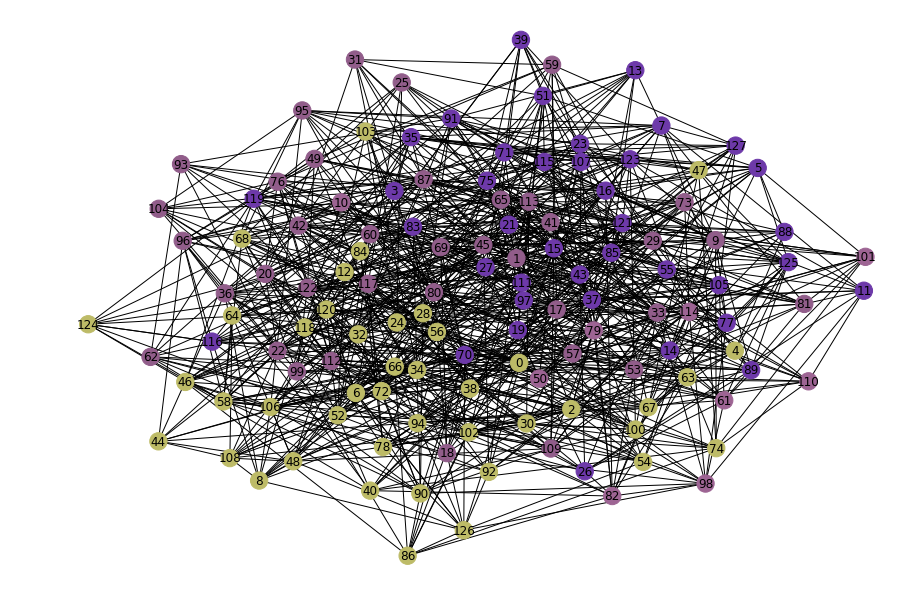

In [44]:
# strongly separated modules
classicGNTest(0.2)

# weakly separated modules
plt.figure()
classicGNTest(4)

# non-modular network
plt.figure()
classicGNTest(8)

In [45]:
def classicGNTest_repeated():
    '''
    This function runs 100 times the greedy community detection for each parameter (Zout) setting of the GN benchmark.
    It creates a plot for each Zout value with the mean and standard deviation of the 100 runs.
    
    '''
    Xdata = np.arange(0.0, 8.2, 0.2)
    fractionOfCorrectlyClustered = []
    for Zout in Xdata:
        fractionOfCorrectlyClustered.append([])
        for i in range(100):
            # Create a Girvan-Newman test graph
            G = girvan_graphs(Zout)
            # Run the community detection
            communities = greedyQ(G)
            communities.sort(key = (lambda community: sorted(list(community))[0]))
            # Assign a community number to each node
            nodeToCommunity_dict = {node : c for c in range(len(communities)) for node in communities[c]}
            correctlyClustered = [node for node in nodeToCommunity_dict if node % 4 == nodeToCommunity_dict[node] % 4]
            fractionOfCorrectlyClustered[-1].append(len(correctlyClustered)/len(G.nodes()))
        
    # New figure
    plt.figure()

    # Set figure size (width, height)
    fig_size = [12, 8]   
    plt.rcParams["figure.figsize"] = fig_size   
    
    # Set axis
    plt.axis([0, 8, 0, 1])
    plt.yticks([x for x in np.arange(0.0, 1.1, 0.1)])
    
    # Plot data
    plt.errorbar(Xdata, [np.mean(datum) for datum in fractionOfCorrectlyClustered], [np.std(datum) for datum in fractionOfCorrectlyClustered], linestyle='-', marker='o')
    
    # Add title and labels
    plt.title("Greedy Community Detection Test on the GN Benchmark", fontsize=20, verticalalignment='bottom')
    plt.xlabel("number of intercommunity edges per node, Zout")
    plt.ylabel("fraction of nodes correctly clustered")  
   
    
    return 

### Testing repeatedly on the GN benchmark with increasing Zout

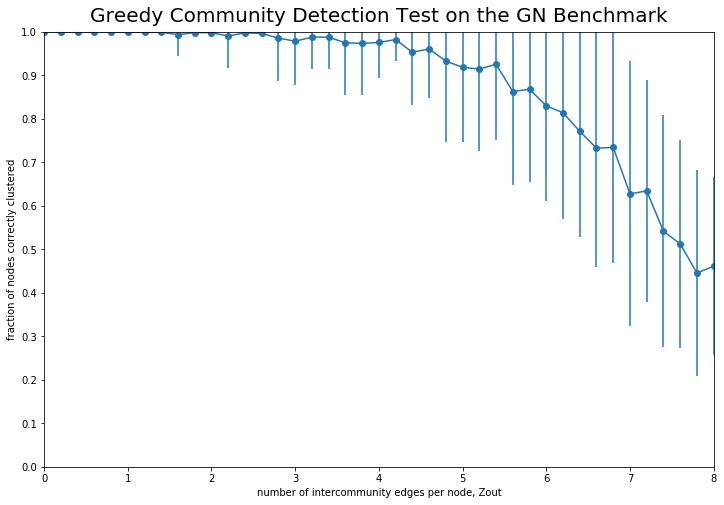

In [46]:
classicGNTest_repeated()

### Testing with undirected, weighted networks

In [9]:
def createTestGraph3():
    '''
    Creates a simple, undirected and weighted test graph with two components.
    In one of the components, there are two communities connected 
    by a birdge with a large weight.
    
    This function uses networx library.
    > import networkx
    
    Example:
    > G = createTestGraph2()
    
    returns G : networkx graph object
    '''
    G = nx.Graph()

    #cluster 1 : 0,1,2
    G.add_edge(0,1, weight=1)
    G.add_edge(0,2, weight=1)
    G.add_edge(1,2, weight=1)
    
    #bridge : it has a relatively big weight!
    G.add_edge(2,3, weight=10)
    
    #cluster 2 : 3,4,5,6
    G.add_edge(3,4, weight=1)
    G.add_edge(3,5, weight=1)
    G.add_edge(3,6, weight=1)
    G.add_edge(4,5, weight=1)
    G.add_edge(4,6, weight=1)
    G.add_edge(5,6, weight=1)
    
    G.add_edge(7,8, weight=1)
    G.add_edge(7,9, weight=1)
    G.add_edge(8,9, weight=1)  
    
    return G

In [16]:
def weightedTest():
    '''
    Runs a simple test with an undirected and weighted networks that has multiple components.
    '''
    
    G = createTestGraph3()
    
    nx.draw(G, with_labels = True)
    
    communities = greedyQ(G, weighted=True)
    # Assign a community number to each node
    nodeToCommunity_dict = {node : c for c in range(len(communities)) for node in communities[c]}
        
    # Assign a random color to each community (RGB code in a tuple)
    communityToColor_dict = {c : (random(), random(), random()) for c in range(len(communities))}
    
    # Assign each a color to each node
    nodeColors = [communityToColor_dict[nodeToCommunity_dict[node]] for node in G.nodes()]
    
    # Draw network, each community has a different random color
    plt.figure()
    nx.draw(G, node_color = nodeColors, with_labels = True)    
    
    return communities

[frozenset({4, 5, 6}),
 frozenset({7, 8, 9}),
 frozenset({0, 1}),
 frozenset({2, 3})]

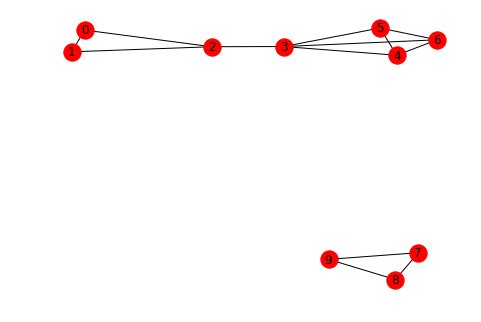

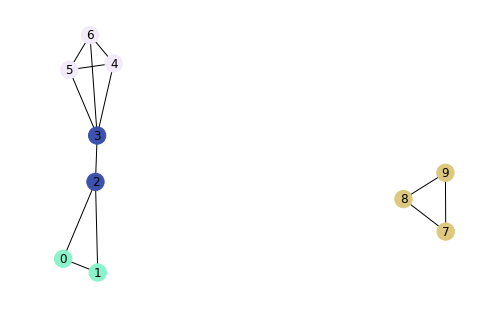

In [17]:
# Testing with a weighted graph
plt.figure()
weightedTest()